In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/'My Drive'/Mask_RCNN-master/samples/bee

/content/gdrive/My Drive/Mask_RCNN-master/samples/bee


In [0]:
#%cd /root
#%rm bee.py
#from google.colab import files
#uploaded=files.upload()
#for fn in uploaded.keys():
 # print('User uploaded file "{name}"with length {length}bytes'.format(name=fn,length=len(uploaded[fn])))


In [3]:

# Root directory of the project
ROOT_DIR = "/content/gdrive/My Drive/Mask_RCNN-master/samples/bee"

# Import Mask RCNN
#sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import sys
sys.path.append(ROOT_DIR)

from bee import beeConfig as bC
from bee import BeeDataset as bD

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
BEE_WEIGHTS_PATH = "/content/gdrive/My Drive/Mask_RCNN-master/samples/bee/logs/mask_rcnn_bee.h5"  # TODO: update this path

Using TensorFlow backend.


In [0]:
#!pip install mrcnn

In [5]:
%ls
import bee as Bee

bee1.py  DataSet/                inspect_bee_model.ipynb  mrcnn/
bee.py   inspect_bee_data.ipynb  logs/                    __pycache__/


In [6]:
from bee import beeConfig
print(beeConfig)

<class 'bee.beeConfig'>


In [0]:

config = bC()
BEE_DIR = os.path.join(ROOT_DIR, "DataSet")

In [8]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                15
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [0]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Code Thibaud

### Install and load python modules

In [0]:
from mrcnn import utils
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

In [0]:
import os
import sys
import skimage
#print(sys.path)
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Root directory of the project


# Import Mask RCNN
#sys.path.append(ROOT_DIR) # To find local version of the library
from mrcnn import utils
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

### Implement class BeeDataset directly in google collab.

In [0]:
class BeeDataset(utils.Dataset):

    def load_bee(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("insect", 1, "abeille")
        self.add_class("insect", 2, "frelon")
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
  
        annotations = json.load(open(os.path.join(dataset_dir, "Abeille.json")))
        #annotations=[annotations['_via_img_metadata'][image] for image in annotations['_via_img_metadata'].keys()]
        #annotations = list(annotations.values())  # don't need the dict keys
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        #annotations = [a for a in annotations if a['regions']]
        if subset == "train": 
            annotations = [annotations[key] for key in annotations.keys()][15:16]  # TODO : To remove fter end of DEV
        elif subset == "val":
            annotations=[annotations['_via_img_metadata'][image] for image in annotations['_via_img_metadata'].keys()][1:2] # TODO : To remove fter end of DEV
        else:
            raise ValueError("unknown subset")

        # Add images
        for a in annotations:
          num_ids = []    
           # # Get the x, y coordinaets of points of the polygons that make up
            ## the outline of each object instance. These are stores in the
           # # shape_attributes (see json format above)
            ## The if condition is needed to support VIA versions 1.x and 2.x.
            
          polygons=[s['shape_attributes'] for s in a['regions']]
           # print("polygons",polygons)
          objects = [r['region_attributes'] for r in a['regions']]
           # print("\n\n")
           # print("annotation : %s / %s" % (i, len(annotations)))
            #print("detected %s polygons" % len(polygons))
           # j = 1 
            #for poly in polygons: 
              #  print("polygon %s  : all points y" % j)
               # try: 
                #    print(poly["all_points_y"])
                #except: 
                 #   print("ERROR !!!!!!!")
                  #  print(poly)
                #j += 1

            #i += 1
          for n in objects:
            try:
              if 'Abeille' in n.values():
                num_ids.append(1)
              elif 'Frelon' in n.values():
                num_ids.append(2)
            except:
              pass
            
          image_path = os.path.join(dataset_dir, a['filename'])
          try: # Try in the val folder
            image = skimage.io.imread(image_path)
          except: # try in the train folder
            image_path_train = os.path.join(os.path.join(dataset_dir, "../train/Abeilles"), a['filename']) 
            image = skimage.io.imread(image_path_train)
              
          height, width = image.shape[:2]

          self.add_image(
            "insect",
            image_id=a['filename'],  # use file name as a unique image id
            path=image_path,
            width=width, height=height,
            polygons=polygons,
            num_ids=num_ids)
    
    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a bee dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "insect":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
            
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), image_info['num_ids']

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "balloon":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = BeeDataset()
    dataset_train.load_bee(args.dataset, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = BeeDataset()
    dataset_val.load_bee(args.dataset, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=30,
                layers='heads')


def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]
    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray.astype(np.uint8)
    return splash


def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        print("Running on {}".format(args.image))
        # Read image
        image = skimage.io.imread(args.image)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)


### Load pictures from local and unzpip it

### Process dataset

In [0]:

BEE_DIR="/content/gdrive/My Drive/Mask_RCNN-master/samples/bee/DataSet"

In [56]:
dataset = BeeDataset()
dataset.load_bee(BEE_DIR, "val") #TODO remplacer par val

# Must call before using the dataset
dataset.prepare()
print(dataset.image_ids)
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

[0]
Images: 1
Classes: ['BG', 'abeille', 'frelon']


## Fin code Thibaud

In [16]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

W0625 07:34:28.753696 140396380440448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 07:34:28.765367 140396380440448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 07:34:28.780753 140396380440448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 07:34:28.834231 140396380440448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0625 07:34:28.838931 140396380

In [0]:
def my_find_last(self):
        """Finds the last checkpoint file of the last trained model in the
        model directory.
        Returns:
            The path of the last checkpoint file
        """
        # Get directory names. Each directory corresponds to a model
        print(next(os.walk(self.model_dir)))
        dir_names = next(os.walk(self.model_dir))[1]
        key = self.config.NAME.lower()
        dir_names=[dir_names[0]]
        #dir_names = filter(lambda f: f.startswith(key), dir_names)
        print("dir_name",dir_names)
        print(" filter",filter(lambda f: f.startswith(key), dir_names))
        #dir_names = sorted(dir_names)
        #print("dir_name",dir_names)
        #if not dir_names:
           # import errno
            #raise FileNotFoundError(
               # errno.ENOENT,
                #"Could not find model directory under {}".format(self.model_dir))
        # Pick last directory
        dir_name = os.path.join(self.model_dir, dir_names[-1])
        print("dir_name",dir_name)
        # Find the last checkpoint
        print(next(os.walk(dir_name)))
        checkpoints = next(os.walk(dir_name))[-1]
        checkpoints_f = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
        print("checkpoint",checkpoints)
        #checkpoints_f = sorted(checkpoints_f)
        print("checkpoint_f",checkpoints_f)
        if not checkpoints_f:
            import errno
            raise FileNotFoundError(
                errno.ENOENT, "Could not find weight files in {}".format(dir_name))
        checkpoint = os.path.join(dir_name, checkpoints[-1])
        return checkpoint

In [0]:
# Patch find_last
model.find_last = lambda: my_find_last(model)


In [19]:
model.find_last()

('/content/gdrive/My Drive/Mask_RCNN-master/samples/bee/logs', ['abeille20190617T1418', 'abeille20190624T1347'], [])
dir_name ['abeille20190617T1418']
 filter <filter object at 0x7fb04d81b048>
dir_name /content/gdrive/My Drive/Mask_RCNN-master/samples/bee/logs/abeille20190617T1418
('/content/gdrive/My Drive/Mask_RCNN-master/samples/bee/logs/abeille20190617T1418', [], ['mask_rcnn_bee.h5'])
checkpoint ['mask_rcnn_bee.h5']
checkpoint_f <filter object at 0x7fb04d81b978>


'/content/gdrive/My Drive/Mask_RCNN-master/samples/bee/logs/abeille20190617T1418/mask_rcnn_bee.h5'

In [20]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
#model.load_weights(weights_path, by_name=True)
model.load_weights(weights_path, by_name=True, exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

('/content/gdrive/My Drive/Mask_RCNN-master/samples/bee/logs', ['abeille20190617T1418', 'abeille20190624T1347'], [])
dir_name ['abeille20190617T1418']
 filter <filter object at 0x7fb04d81bf60>
dir_name /content/gdrive/My Drive/Mask_RCNN-master/samples/bee/logs/abeille20190617T1418
('/content/gdrive/My Drive/Mask_RCNN-master/samples/bee/logs/abeille20190617T1418', [], ['mask_rcnn_bee.h5'])
checkpoint ['mask_rcnn_bee.h5']
checkpoint_f <filter object at 0x7fb05b6d2cc0>
Loading weights  /content/gdrive/My Drive/Mask_RCNN-master/samples/bee/logs/abeille20190617T1418/mask_rcnn_bee.h5


In [0]:
 def my_detect(self, images, verbose=0):
        """Runs the detection pipeline.

        images: List of images, potentially of different sizes.

        Returns a list of dicts, one dict per image. The dict contains:
        rois: [N, (y1, x1, y2, x2)] detection bounding boxes
        class_ids: [N] int class IDs
        scores: [N] float probability scores for the class IDs
        masks: [H, W, N] instance binary masks
        """
        print("len(images): ",len(images))
        print("gpu",self.config.GPU_COUNT)
        print("im_gpu",self.config.IMAGES_PER_GPU)
        print("Batch",self.config.GPU_COUNT * self.config.IMAGES_PER_GPU)
        assert self.mode == "inference", "Create model in inference mode."
        assert len(
            images) == self.config.GPU_COUNT * self.config.IMAGES_PER_GPU, "len(images) must be equal to BATCH_SIZE"

        if verbose:
            log("Processing {} images".format(len(images)))
            for image in images:
                log("image", image)

        # Mold inputs to format expected by the neural network
        molded_images, image_metas, windows = self.mold_inputs(images)

        # Validate image sizes
        # All images in a batch MUST be of the same size
        image_shape = molded_images[0].shape
        for g in molded_images[1:]:
            assert g.shape == image_shape,\
                "After resizing, all images must have the same size. Check IMAGE_RESIZE_MODE and image sizes."

        # Anchors
        anchors = self.get_anchors(image_shape)
        # Duplicate across the batch dimension because Keras requires it
        # TODO: can this be optimized to avoid duplicating the anchors?
        anchors = np.broadcast_to(anchors, (self.config.BATCH_SIZE,) + anchors.shape)

        if verbose:
            log("molded_images", molded_images)
            log("image_metas", image_metas)
            log("anchors", anchors)
        # Run object detection
        detections, _, _, mrcnn_mask, _, _, _ =\
            self.keras_model.predict([molded_images, image_metas, anchors], verbose=0)  ##PROBLEME ICI 
        #print("detections",detections)
        # Process detections
        results = []
        for i, image in enumerate(images):
            final_rois, final_class_ids, final_scores, final_masks =\
                self.unmold_detections(detections[i], mrcnn_mask[i],
                                       image.shape, molded_images[i].shape,
                                       windows[i])
            results.append({
                "rois": final_rois,
                "class_ids": final_class_ids,
                "scores": final_scores,
                "masks": final_masks,
            })
        return results

image ID: insect.0141.jpeg (0) None
len(images):  1
gpu 1
im_gpu 1
Batch 1
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
detection unmold:  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
N unmold:  19
[[ 657   73  837  709]
 [ 313  330  357  437]
 [ 203  354  328  705]
 [ 440  442  510  469]
 [   0  285  569  912]
 [ 184  534  305  839]
 [ 535    3  574   19]
 [ 698  551  766  720]
 [

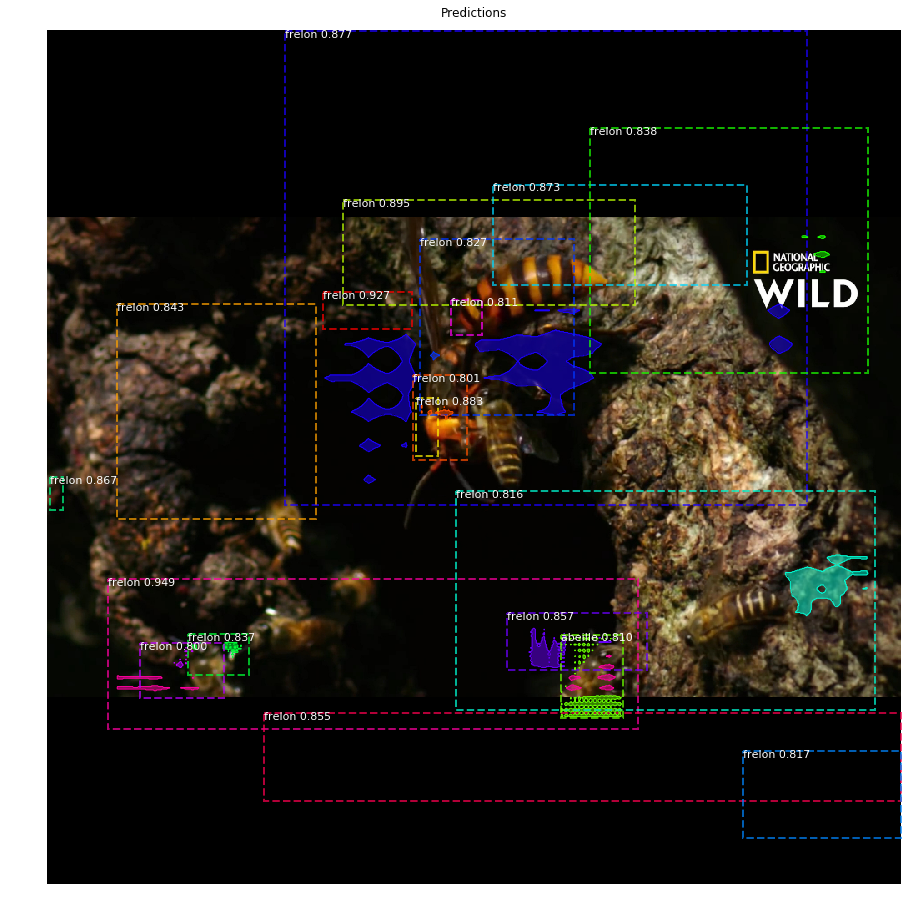

In [57]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
#image, window, scale, padding, _ = utils.resize_image(
#    image, 
#    min_dim=config.IMAGE_MIN_DIM, 
#    max_dim=config.IMAGE_MAX_DIM,
#    mode=config.IMAGE_RESIZE_MODE)
#mask = utils.resize_mask(mask, scale, padding)


image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = my_detect(model,[image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

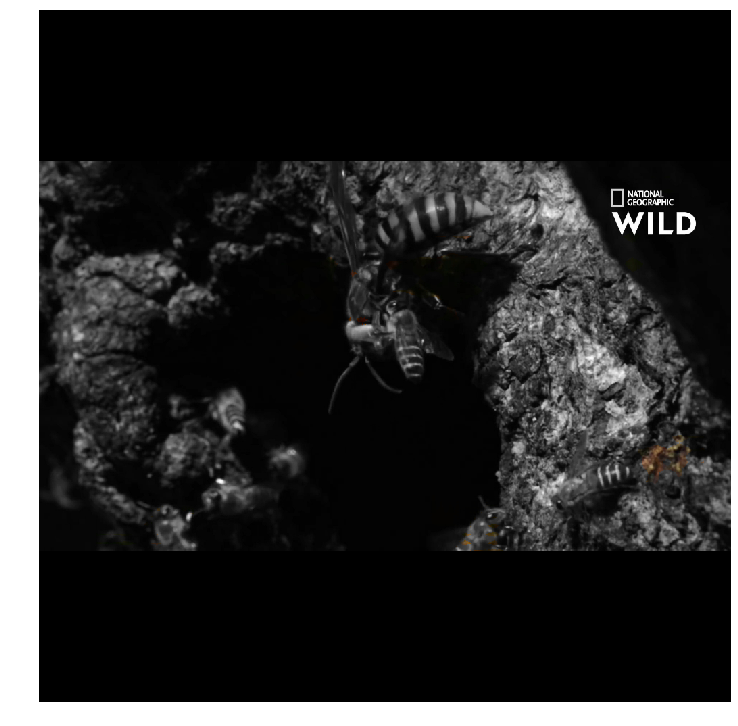

In [58]:
splash = color_splash(image, r['masks'])
display_images([splash], cols=1)

In [59]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -3.25932  max:    3.81175  float64
positive_anchors         shape: (26, 4)               min:  160.00000  max:  896.00000  float64
negative_anchors         shape: (230, 4)              min:  -58.50967  max: 1053.25483  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (26, 4)               min:  167.00000  max:  882.00000  float32


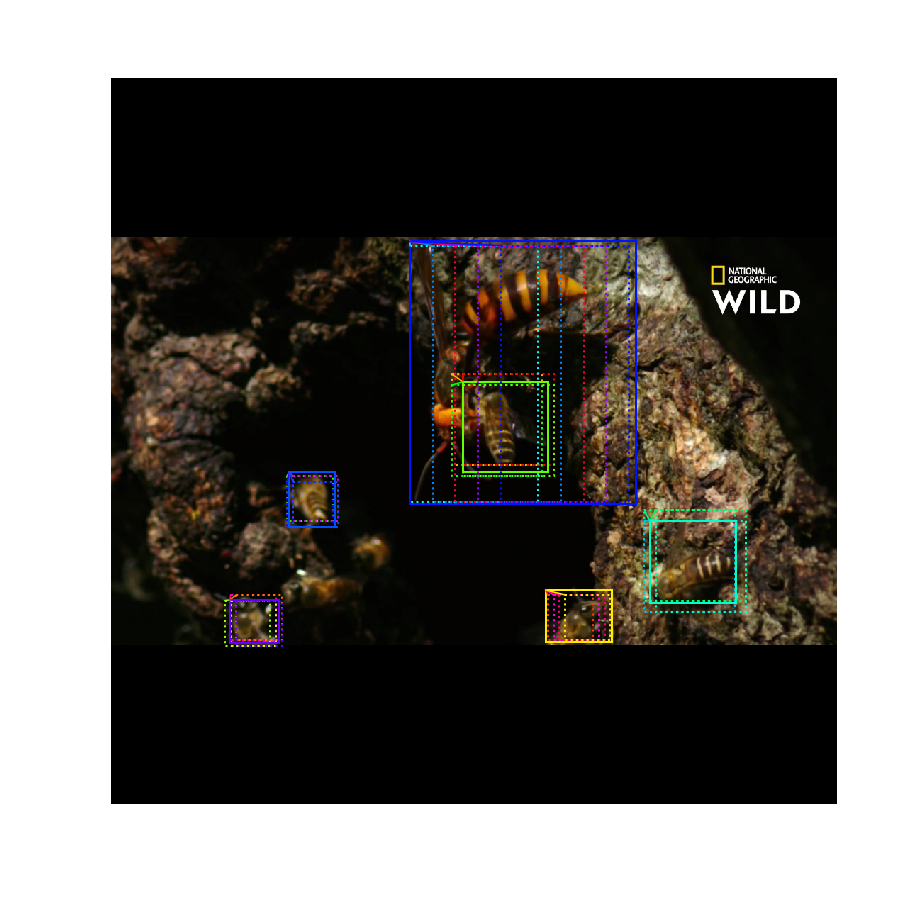

In [60]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

In [61]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35390  max:    1.29134  float32
refined_anchors          shape: (1, 6000, 4)          min:   -5.33220  max:    6.35705  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (1000,)               min:    0.00000  max: 5206.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


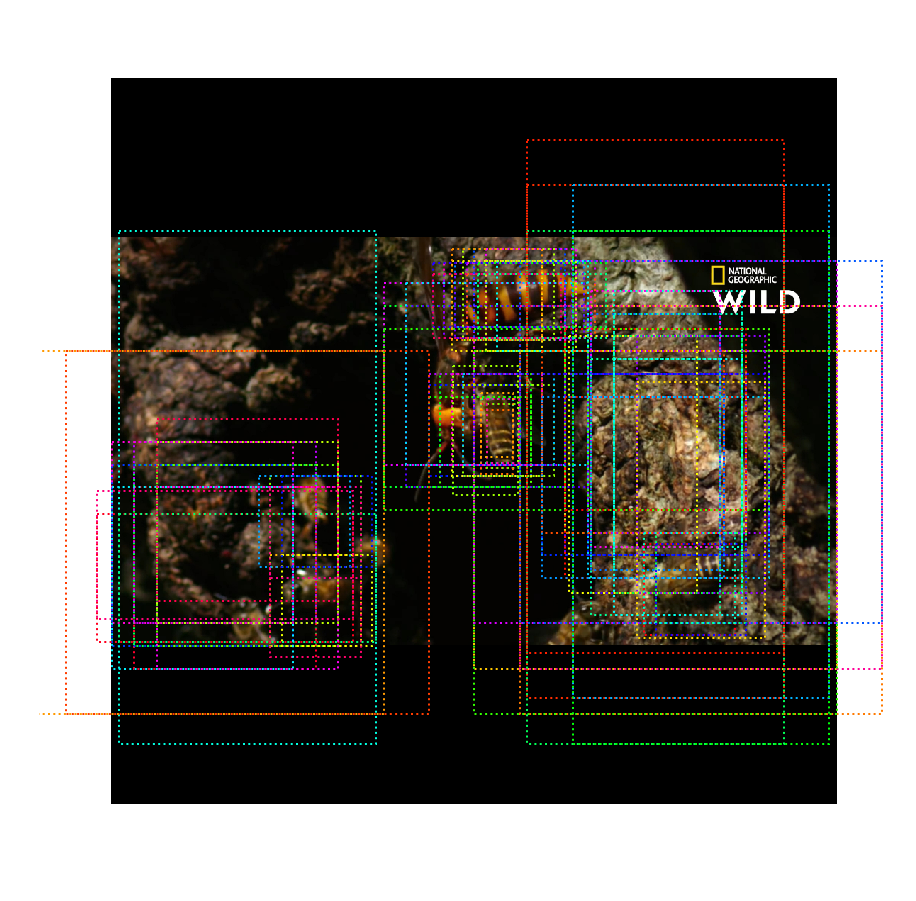

In [62]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

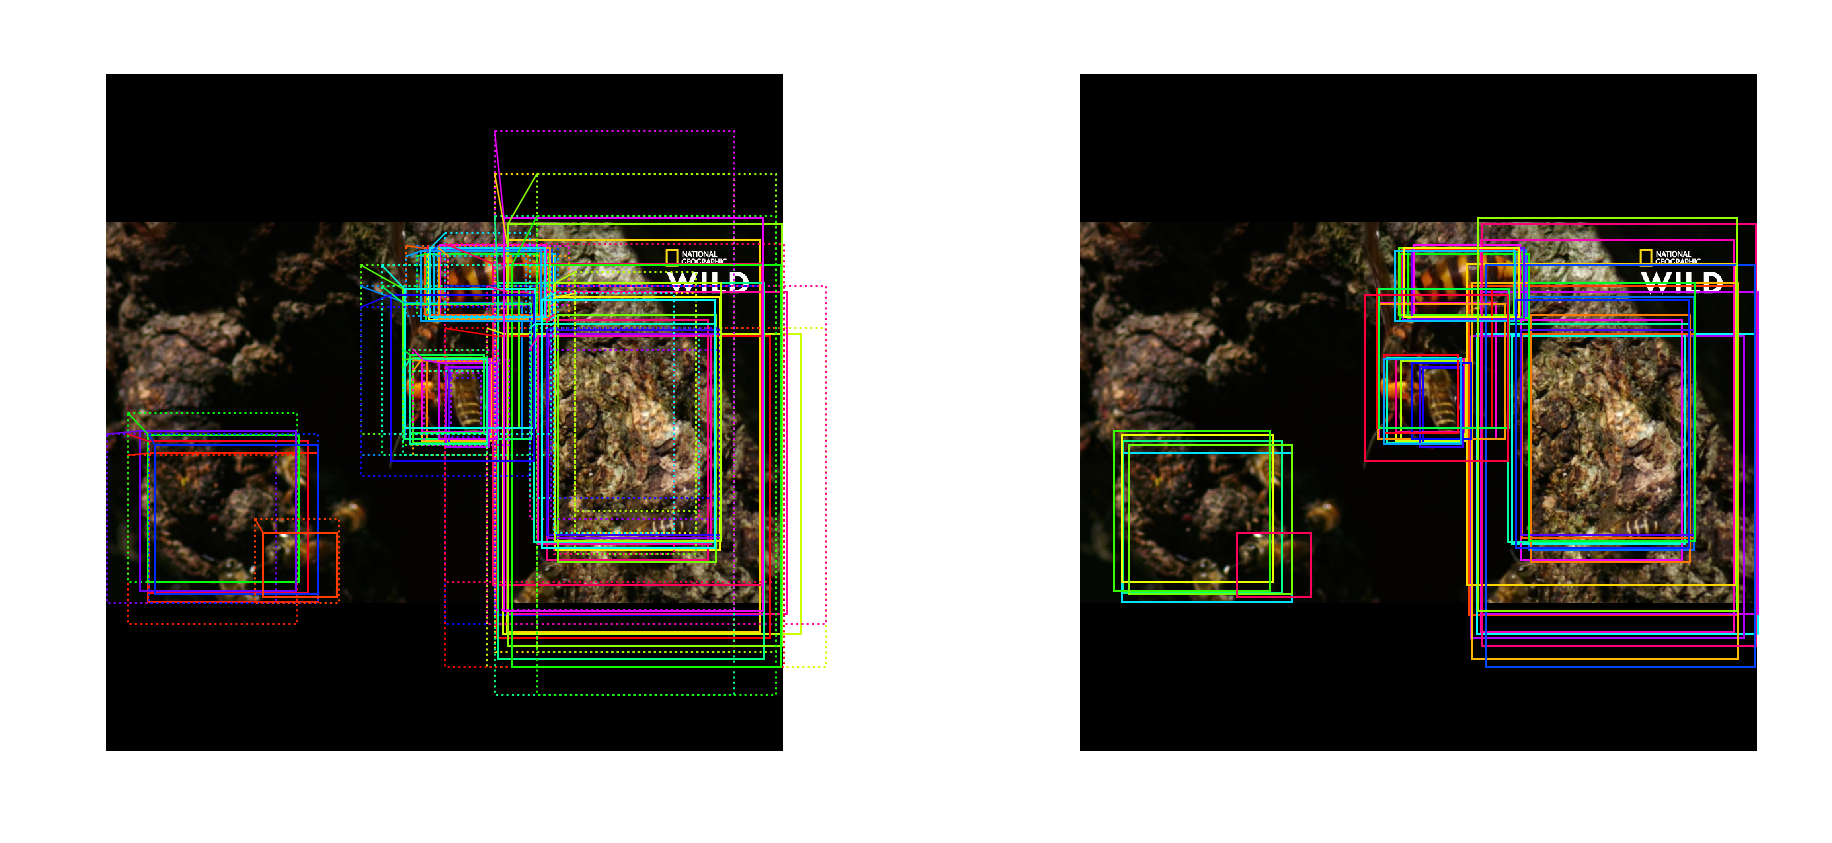

In [63]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 50
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

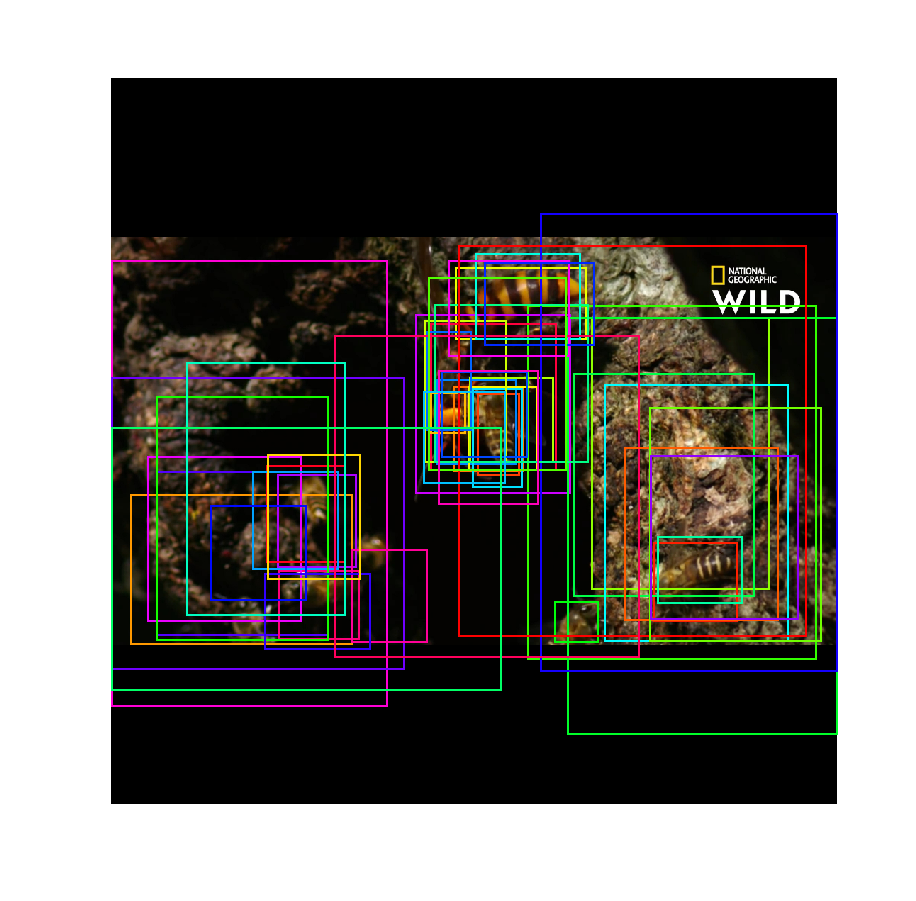

In [64]:
# Show refined anchors after non-max suppression
limit = 50
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

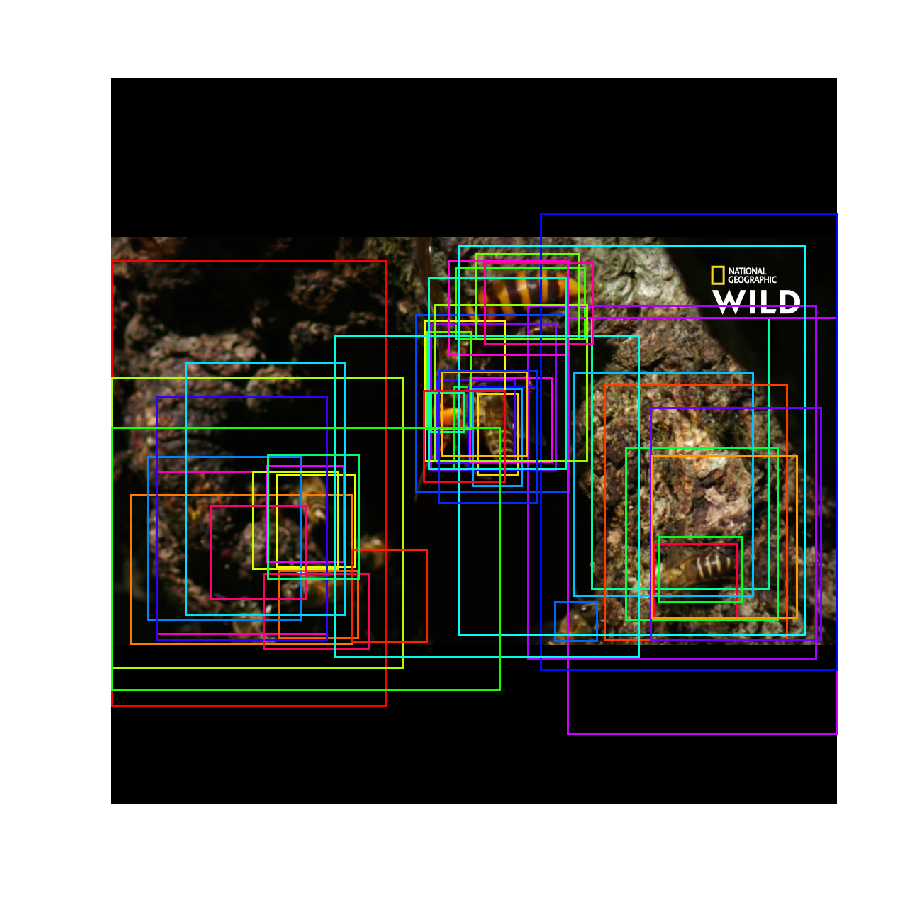

In [65]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 50
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())


In [66]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 3)          min:    0.01454  max:    0.94936  float32
deltas                   shape: (1, 1000, 3, 4)       min:   -3.98416  max:    4.09893  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.01774  max:    0.77077  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32


19 detections: ['frelon' 'frelon' 'frelon' 'frelon' 'frelon' 'frelon' 'frelon' 'frelon'
 'frelon' 'frelon' 'frelon' 'frelon' 'frelon' 'frelon' 'frelon' 'frelon'
 'abeille' 'frelon' 'frelon']


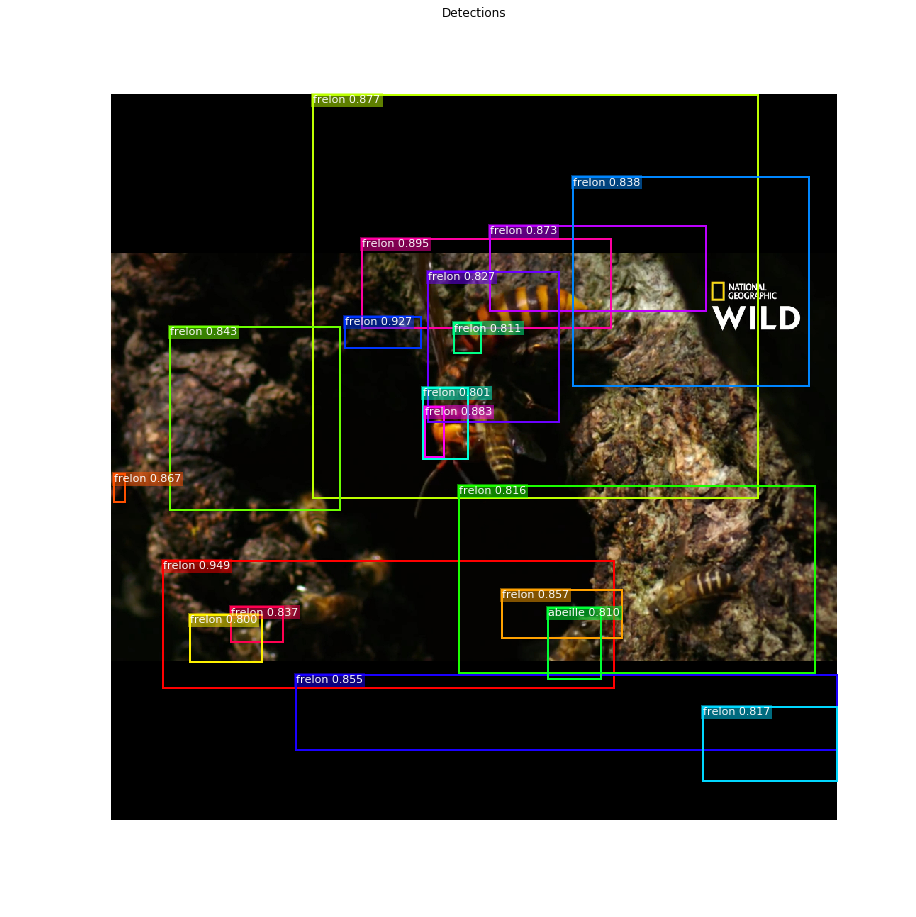

In [67]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [33]:
mrcnn['detections'][0, :, 4].astype(np.int32)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [34]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
836 Positive ROIs
[('BG', 164), ('abeille', 238), ('frelon', 598)]


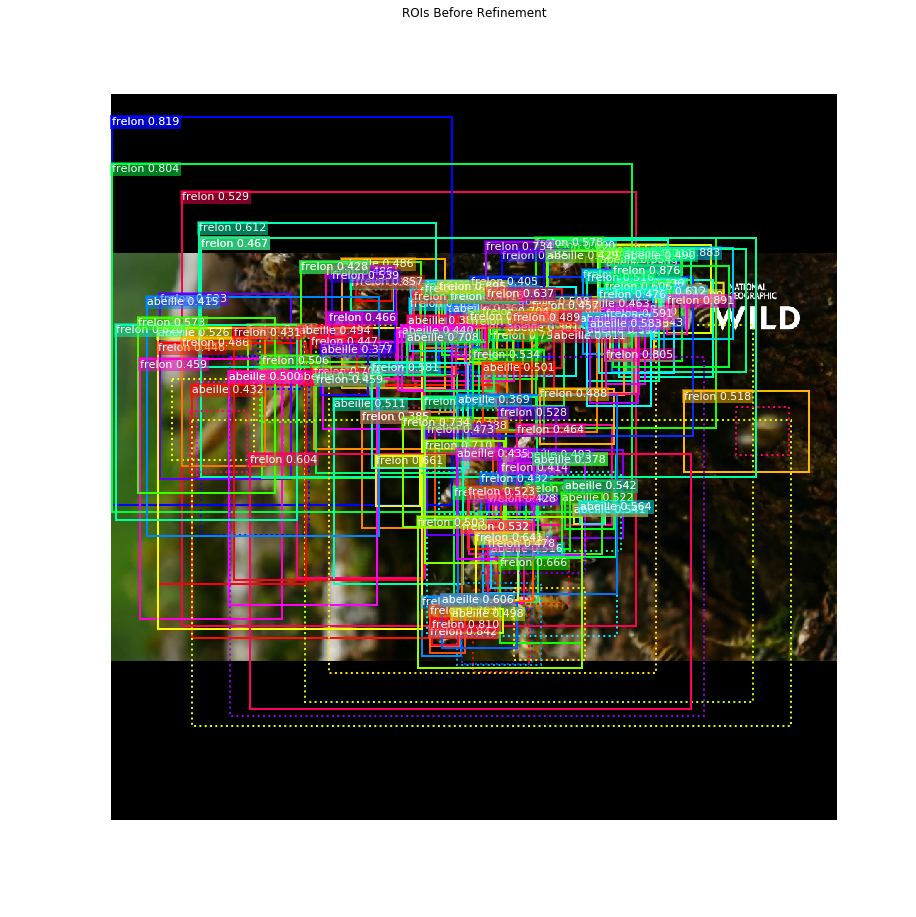

In [35]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 200
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

roi_bbox_specific        shape: (1000, 4)             min:   -3.50286  max:    4.28667  float32
refined_proposals        shape: (1000, 4)             min: -174.00000  max: 1079.00000  int32


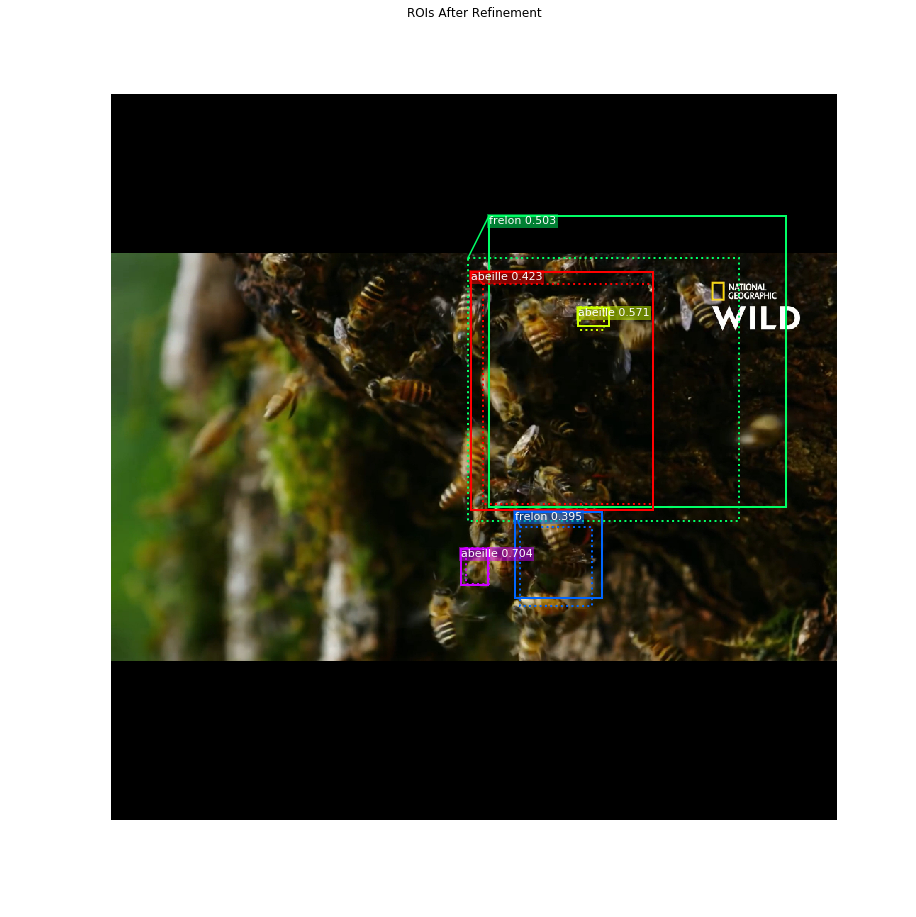

In [36]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

In [37]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 836 detections:
[  1   2   3   4   6   7   8   9  10  12  13  16  17  18  19  20  21  24
  25  26  27  30  31  32  33  35  36  37  39  40  42  43  44  46  47  48
  49  50  51  52  54  55  56  57  58  59  60  61  62  63  66  67  68  69
  70  71  73  74  76  77  78  79  80  81  82  83  84  85  87  88  90  91
  93  94  95  97  98  99 100 101 102 104 105 106 108 109 110 111 112 114
 115 117 118 119 121 122 123 124 125 128 130 131 132 133 134 136 137 138
 140 141 142 144 146 147 148 149 150 151 152 154 156 157 158 159 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 181 182 183
 184 185 186 187 188 189 191 192 193 194 195 197 198 199 200 202 203 204
 205 209 210 211 212 213 215 216 217 218 219 220 221 223 224 225 226 227
 228 230 231 232 233 235 236 237 238 240 241 242 243 244 245 247 248 249
 250 252 254 255 256 257 258 259 262 263 264 265 266 267 268 269 271 272
 274 275 276 277 279 280 281 283 284 285 286 287 288 289 290 291 292 293
 294 296 297 298 299 301 302 3

In [38]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.8 confidence. Keep 48:
[ 24  36  44 101 211 212 298 332 334 356 380 390 414 444 452 490 493 496
 505 569 582 587 598 632 633 638 639 707 708 779 790 817 832 841 855 869
 880 897 911 917 923 925 928 951 952 954 989 997]


In [39]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

frelon                : [ 24  36  44 101 211 212 298 332 334 356 380 390 414 444 452 490 493 496
 505 569 582 587 598 632 633 638 639 707 708 779 790 817 832 841 855 869
 880 897 911 917 923 925 928 951 952 954 989 997] -> [855 334 490 880 954 925 997 923 390 989 911 452 790 707 951]

Kept after per-class NMS: 15
[334 390 452 490 707 790 855 880 911 923 925 951 954 989 997]


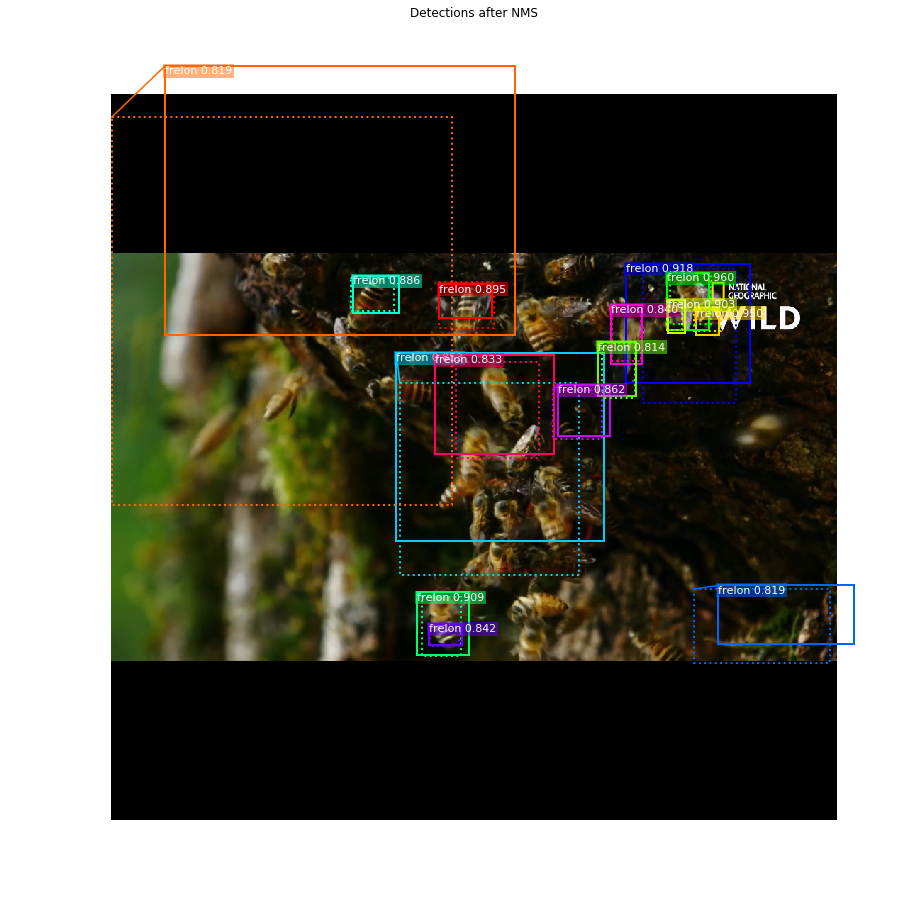

In [40]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

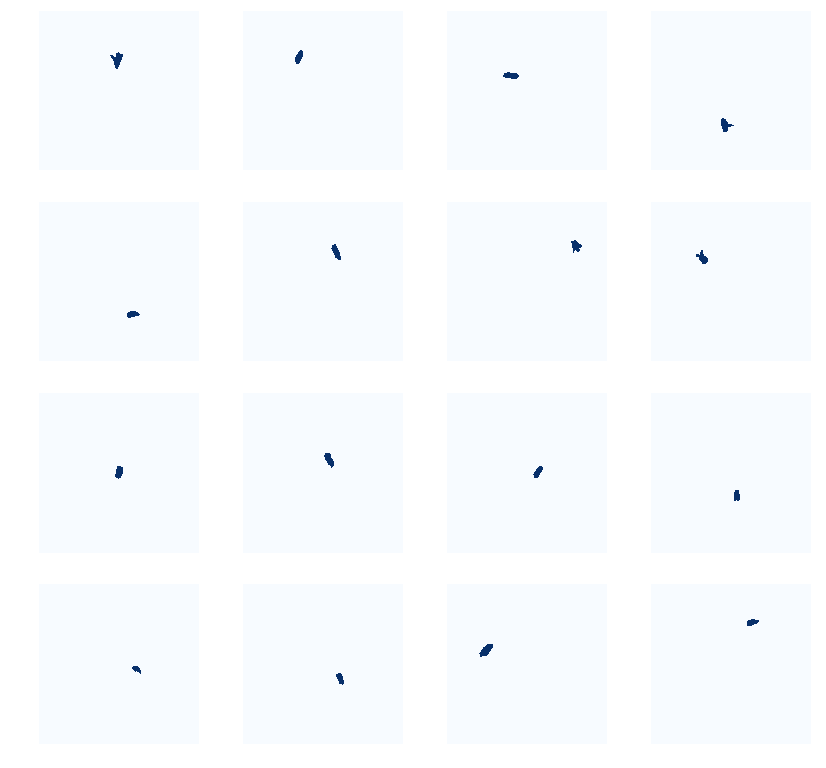

In [41]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

In [42]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
#mrcnn['detections'][0]=0
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    2.00000  float32
masks                    shape: (1, 100, 28, 28, 3)   min:    0.02661  max:    0.84185  float32
14 detections: ['frelon' 'frelon' 'frelon' 'frelon' 'frelon' 'frelon' 'frelon' 'frelon'
 'frelon' 'frelon' 'frelon' 'frelon' 'frelon' 'frelon']


In [43]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

det_mask_specific        shape: (14, 28, 28)          min:    0.08471  max:    0.59101  float32
det_masks                shape: (14, 1024, 1024)      min:    0.00000  max:    1.00000  bool


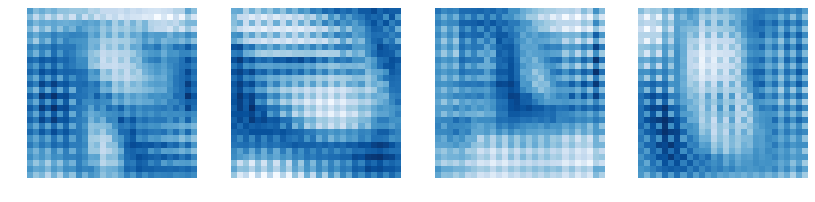

In [44]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

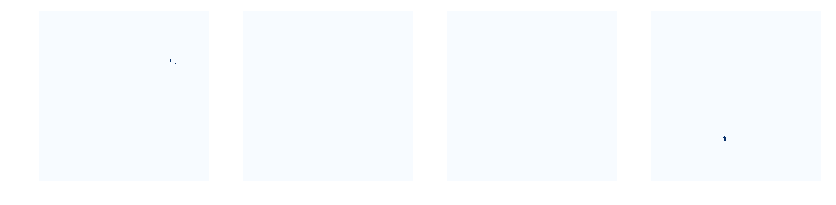

In [45]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

In [46]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
    ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
    ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10001  float32
res2c_out                shape: (1, 256, 256, 256)    min:    0.00000  max:   35.34326  float32
res3c_out                shape: (1, 128, 128, 512)    min:    0.00000  max:   32.20536  float32
res4w_out                shape: (1, 64, 64, 1024)     min:    0.00000  max:   57.78454  float32
rpn_bbox                 shape: (1, 261888, 4)        min:   -5.96285  max:   80.46928  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


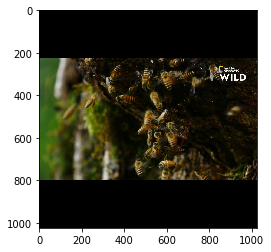

In [47]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

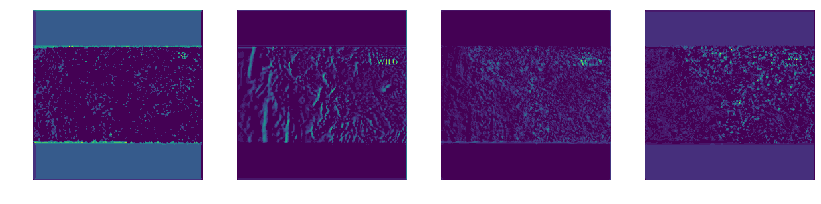

In [48]:
# Backbone feature map
display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)